# Data Cleaning

This notebook compiles everyone's data cleaning code together.

The overall objective of the data cleaning step is to process raw datasets (credits.csv, keywords.csv, and movies_metadata.csv) into a single dataframe that is ready for feature transformation and unsupervised learning. Here below are more specific objectives to clean the data:

1. Load and merge tables related to the content of movies (credits.csv, keywords.csv, and movies_metadata.csv)
2. Clean features that have collections of data, e.g. [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}]
3. Assess missing data in each column
4. Feature engineering
    - Create weighted rating column to account for both vote_count and vote_average
    - Process poster images to identify darkness and colorfulness of the overall image
    - Retrieve information from paragraphs of text
    - Convert categorical features into binary values
    - Re-encode other non-numeric features
5. Assess missing data in each row
6. Feature scaling (to be addressed as the first step in machine learning)

This notebook is followed by `content_based_recommender.ipynb`, which conducts feature transformations and constructs unsupervised learning algorithms to provide movie recommendations.

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from ast import literal_eval
import ast
import random
from skimage import io
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Input data files are available in the "../input/" directory.
from subprocess import check_output
# print(check_output(["ls", "../Final_Project/Data"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

from sklearn.preprocessing import Imputer
from sklearn.feature_extraction.text import TfidfVectorizer

## 1. Load and merge tables

#### Load all the raw data related to the content of movies

- `credits.csv`
- `keywords.csv`
- `movies_metadata.csv`

In [2]:
# Load tables into dataframes
PATH = "Data/"
df_credits = pd.read_csv(PATH+"credits.csv")
df_keywords = pd.read_csv(PATH+"keywords.csv")
df = pd.read_csv(PATH+"movies_metadata.csv")

# Preview metadata
print("movies_metadata.csv:")
print(f"Row, col: {df.shape}\n")
print(df.dtypes)
df.head(2)

movies_metadata.csv:
Row, col: (45466, 24)

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object


/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [3]:
# Preview credits
print("credits.csv:")
print(f"Row, col: {df_credits.shape}\n")
print(df_credits.dtypes)
df_credits.head()

credits.csv:
Row, col: (45476, 3)

cast    object
crew    object
id       int64
dtype: object


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
# Preview keywords
print("keywords.csv:")
print(f"Row, col: {df_keywords.shape}\n")
print(df_keywords.dtypes)
df_keywords.head()

keywords.csv:
Row, col: (46419, 2)

id           int64
keywords    object
dtype: object


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


#### Assess keys for relational join

From above, `id` column in each dataframe is the key to perform relational join

In [5]:
# Check the number of null id's in each dataframe
print(f"Number of null id in metadata table: {df['id'].isnull().sum()}")
print(f"Number of null id in credits table: {df_credits['id'].isnull().sum()}")
print(f"Number of null id in keywords table: {df_keywords['id'].isnull().sum()}")

Number of null id in metadata table: 0
Number of null id in credits table: 0
Number of null id in keywords table: 0


In [6]:
# Find 3 bad id's in metadata table!
print (df['id'][pd.to_numeric(df['id'], errors='coerce').isnull()])

19730    1997-08-20
29503    2012-09-29
35587    2014-01-01
Name: id, dtype: object


These are clearly rows with erroneous data. Need to drop these rows.

In [7]:
# Drop rows that have bad id's
df["id"] =pd.to_numeric(df['id'], errors='coerce',downcast="integer")
# df["imdb_id"] =pd.to_numeric(df['imdb_id'], errors='coerce',downcast="integer")
df.dropna(subset=["id"],inplace=True)
print("movies_metadata.csv:")
print(f"Row, col: {df.shape}\n")
print(df[['id']].dtypes)

movies_metadata.csv:
Row, col: (45463, 24)

id    float64
dtype: object


Check whether the id's are unique, aka., no duplicate rows. Then drop duplicate rows if there is any.

In [8]:
# Check whether there are duplicate rows
print(f"Number of unique movie id's in metadata table: {df['id'].nunique()}")
print(f"Number of unique movie id's in credits table: {df_credits['id'].nunique()}")
print(f"Number of unique movie id's in keywords table: {df_keywords['id'].nunique()}")

Number of unique movie id's in metadata table: 45433
Number of unique movie id's in credits table: 45432
Number of unique movie id's in keywords table: 45432


In [9]:
# Drop duplicate rows in each dataframe
df = df.drop_duplicates(subset=['id', 'imdb_id'])
df_credits = df_credits.drop_duplicates(subset=['id'])
df_keywords = df_keywords.drop_duplicates()
print(f"Number of rows in metadata table: {df.shape[0]}")
print(f"Number of rows in credits table: {df_credits.shape[0]}")
print(f"Number of rows in keywords table: {df_keywords.shape[0]}")

Number of rows in metadata table: 45433
Number of rows in credits table: 45432
Number of rows in keywords table: 45432


#### Merge tables

In [10]:
df = df.merge(df_credits,on=["id"],how="left")
df = df.merge(df_keywords,on=["id"],how="left")

# Preview merged dataframe
print("Merged movie data:")
print(f"Row, col: {df.shape}\n")
df.head(2)

Merged movie data:
Row, col: (45433, 27)



,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


## 2. Clean features that have collections of data

e.g., [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}]

#### Clean genres column

In [11]:
df['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [12]:
# Convert genres from list of dictionaries to list of strings
df['genres'] = df['genres'].fillna('[]').apply(
    literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['genres'][0:5]

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object

#### Clean cast, crew, keywords columns

In [13]:
df[['cast', 'crew', 'keywords']].loc[0]

cast        [{'cast_id': 14, 'character': 'Woody (voice)',...
crew        [{'credit_id': '52fe4284c3a36847f8024f49', 'de...
keywords    [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
Name: 0, dtype: object

In [14]:
# Drop nulls in order to process the list of dictionaries in each cell
df.dropna(subset=["cast","crew","keywords","popularity"],inplace=True)

In [15]:
# Make the list in each cell accessible
df['cast'] = df['cast'].apply(literal_eval)
df['crew'] = df['crew'].apply(literal_eval)
df['keywords'] = df['keywords'].apply(literal_eval)

# Add the size of cast and crew as new features
df['cast_size'] = df['cast'].apply(lambda x: len(x))
df['crew_size'] = df['crew'].apply(lambda x: len(x))

# Convert cast, crew, keywords from list of dictionaries to list of strings
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['cast'] = df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Extract director from crew as a new feature
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
df['director'] = df['crew'].apply(get_director)

In [16]:
# Delete crew column because we already retain most of the useful information about the staff of a movie
df = df.drop(columns = ['crew'])

In [17]:
df[['cast', 'keywords', 'director', 'cast_size', 'crew_size']].head()

,cast,keywords,director,cast_size,crew_size
0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,13,106
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston,26,16
2,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch,7,4
3,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",Forest Whitaker,10,10
4,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer,12,7


#### Clean production_countries column

In [18]:
df['production_countries'][0]

"[{'iso_3166_1': 'US', 'name': 'United States of America'}]"

In [19]:
# Convert from list of dictionaries to list of strings
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['production_countries'].head()

0    [United States of America]
1    [United States of America]
2    [United States of America]
3    [United States of America]
4    [United States of America]
Name: production_countries, dtype: object

#### Clean belongs_to_collection column

In [20]:
df['belongs_to_collection'][0]

"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}"

In [21]:
# Convert from list of dictionaries to list of strings
df['belongs_to_collection'] = df['belongs_to_collection'].fillna("[]").apply(
    ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df['belongs_to_collection'].head()

0              Toy Story Collection
1                               NaN
2         Grumpy Old Men Collection
3                               NaN
4    Father of the Bride Collection
Name: belongs_to_collection, dtype: object

#### Clean spoken_languages column

In [22]:
df['spoken_languages'][0]

"[{'iso_639_1': 'en', 'name': 'English'}]"

In [23]:
## https://www.kaggle.com/rounakbanik/the-story-of-film
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(
    ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df['spoken_languages'].head()

0    1
1    2
2    1
3    1
4    1
Name: spoken_languages, dtype: int64

#### Clean production_companies column

In [24]:
df['production_companies'][0]

"[{'name': 'Pixar Animation Studios', 'id': 3}]"

In [25]:
df['production_companies'] = df['production_companies'].apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].fillna("[]").apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['production_companies'].head()

0                            [Pixar Animation Studios]
1    [TriStar Pictures, Teitler Film, Interscope Co...
2                       [Warner Bros., Lancaster Gate]
3             [Twentieth Century Fox Film Corporation]
4         [Sandollar Productions, Touchstone Pictures]
Name: production_companies, dtype: object

In [26]:
print("Movie data:")
print(f"Row, col: {df.shape}\n")
df.head()

Movie data:
Row, col: (45429, 29)



,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,cast,keywords,cast_size,crew_size,director
0,False,Toy Story Collection,30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",13,106,John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",26,16,Joe Johnston
2,False,Grumpy Old Men Collection,0,"[Romance, Comedy]",NaN,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o...",7,4,Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",10,10,Forest Whitaker
4,False,Father of the Bride Collection,0,[Comedy],NaN,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence, aging, daug...",12,7,Charles Shyer


## 3. Assess missing values in each column

#### Replace 0 budget or revenue with NaNs

In [27]:
# Convert budget to numeric
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

# Replace 0 with NaNs
df['budget'] = df['budget'].replace(0, np.nan)
df['revenue'] = df['revenue'].replace(0, np.nan)

#### Assess missing data in each column

Text(0.5,1,'Proportion of missing data in each column')

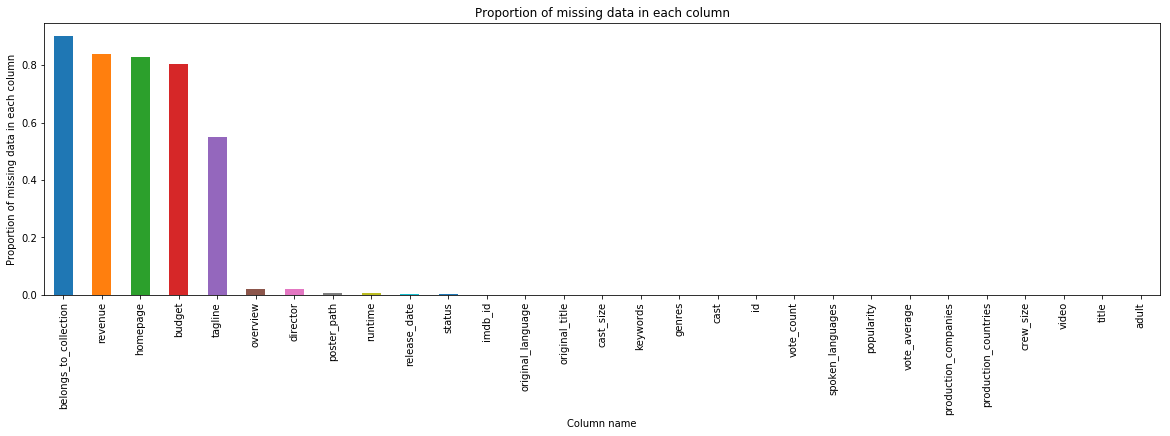

In [28]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_col = df.isnull().sum() / len(df.index)
missing_col.head()

# Investigate patterns in the amount of missing data in each column.
missing_col.sort_values(ascending=False).plot.bar(figsize=(20,5))
plt.xlabel("Column name")
plt.ylabel("Proportion of missing data in each column")
plt.title("Proportion of missing data in each column")

#### Strategies for the columns with missing values:

- `belongs_to_collection` column, convert to dummy variable to represent whether the movie belongs to a collection
- `revenue`, `budget`, and `runtime` columns, use imputation to deal with missing values
- `homepage` column, convert to dummy variable to represent whether a homepage exists, because the exact homepage url (e.g. 'abc.com' vs. 'bcd.com') should not influence customers choice
- `status` column, use only 'released' entries, because we are only interested in released movies for the scope of this project

- `tagline` and `overview` columns will be addressed when performing Natural Language Processing (NLP)
- `director` column will be addressed when converting director to dummies
- `poster path` column will be processed after image processing
- `release date` column will be converted to year, month, and day columns

In [29]:
# Impute `revenue` and `budget` by each column's median
df_clean_col = df
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
df_clean_col[['revenue', 'budget', 'runtime']] = imp.fit_transform(df_clean_col[['revenue', 'budget', 'runtime']])

# Convert `homepage` to dummies (has a homepage: 1, no homepage: 0)
df_clean_col['homepage'] = (df_clean_col['homepage'].isnull())*-1+1

# Convert `belongs_to_collection` to dummies (belongs to a collection: 1, no collection: 0)
df_clean_col['belongs_to_collection'] = (df_clean_col['belongs_to_collection'].isnull())*-1+1

# Use only released movies in this project, select released `status`
df_clean_col = df_clean_col.loc[df_clean_col['status']=='Released']
df_clean_col = df_clean_col.drop(columns=['status'])
df_clean_col.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,cast,keywords,cast_size,crew_size,director
0,False,1,30000000.0,"[Animation, Comedy, Family]",1,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",13,106,John Lasseter
1,False,0,65000000.0,"[Adventure, Fantasy, Family]",0,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",26,16,Joe Johnston
2,False,1,8000000.0,"[Romance, Comedy]",0,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o...",7,4,Howard Deutch
3,False,0,16000000.0,"[Comedy, Drama, Romance]",0,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",10,10,Forest Whitaker
4,False,1,8000000.0,[Comedy],0,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence, aging, daug...",12,7,Charles Shyer


In [30]:
# Column data types
df_clean_col.dtypes

adult                     object
belongs_to_collection      int64
budget                   float64
genres                    object
homepage                   int64
id                       float64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages           int64
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
cast                      object
keywords                  object
cast_size                  int64
crew_size                  int64
director                  object
dtype: object

#### Plans on non-numeric columns:

Columns for feature engineering

- `adult` and `video`: conver False/True to 0 and 1
- `genres`, `director`, `original_language`, `production_companies`, `production_countries`, `cast`, `keywords`: convert to dummies
- `tagline` and `overview`: Natural Language Processing (NLP)
- `poster_path`: delete after image processing that generates new columns on darkness and colorfulness
- `release_date`: convert to year, month, and day columns

Columns not needed in machine learning step

- `id`, `imdb_id`, `original_title`, `title`: delete after all feature engineering before feature scaling

## 4. Feature engineering

- Create weighted rating column to account for both vote_count and vote_average
- Process poster images to identify darkness and colorfulness of the overall image
- Retrieve information from paragraphs of text
- Convert categorical features into binary values
- Re-encode other non-numeric features

### 4.1. Create weighted rating column

Note that neither `vote_count` nor `vote_average` alone is perfect representation of how well-received a movie is. Therefore, we create a new feature to represent weighted ratings based on these 2 columns.

In [31]:
df4 = df_clean_col

# Calculate weighted ratings from vote_count and vote_average columns
vote_counts = df4[df4['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df4[df4['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.75)

def weighted_rating(x):
    v = x['vote_count']+1 # added +1 - Dan
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

df4['weighted_rating'] = df4.apply(weighted_rating, axis=1)

In [ ]:
# Save checkpoint
df4.to_csv("Data/data_cleaning_41.csv", index=False)

### 4.2. Process poster images to identify darkness and colorfulness of the overall image

The goal here is to represent darkness and colorfulness in a quantitative and consistent manner. The method we used here is both able to yield meaningful results and easy to implement:

- **Darkness**: we use the average of RGB values within the entire image as a first-order representation of overall darkness of an image
- **Colorfulness**: we first calculate the variance of R, G, and B respectively within the entire image, and then take an average of the 3 variances. This avoids accounting for the internal variability of R, G, and B of a single pixle.

Because fetching image data from image urls takes time, we process this step in a separate notebook [`process_images.ipynb`](process_images.ipynb), which returns the same dataframe with darkness and colorfulness columns.

In [34]:
# Load checkpoint from process_images.ipynb
df4 = pd.read_csv("Data/data_cleaning_42.csv")

In [35]:
# Impute missing values for columns darkness and colorfulness using the mean
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
df4[['darkness', 'colorfulness']] = imp.fit_transform(
    df4[['darkness', 'colorfulness']])

### 4.3. Retrieve information from paragraphs of text

#### Process movie overview and tagline text using natural language processing (NLP)

In [36]:
# Treat overview and tagline together
df4['description'] = df4['overview'].fillna('') + df4['tagline'].fillna('')
df4['description'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: description, dtype: object

In [37]:
# build a vocabulary that only consider the top 100 ordered by term frequency across the corpus, 
# composed by the main unigrams and bigrams found in the corpus, 
# ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     max_features=100,
                     stop_words='english')

tfidf_matrix = vectorizer.fit_transform(df4['description'])
tfidf_feature_names = vectorizer.get_feature_names()

# Sanity check
print(f'Row, col: {tfidf_matrix.shape}')

Row, col: (44984, 100)


In [38]:
# Create dataframe out of the tfidf matrix
sdf = pd.DataFrame(data = tfidf_matrix.toarray(), 
                   columns=['overview_'+word for word in tfidf_feature_names]).fillna(0)
sdf[df4.columns.tolist()] = df4

# Drop overview, tagline, and description columns because they are already vectorized with NLP
sdf = sdf.drop(columns=['description', 'overview', 'tagline'])
print(f'Row, col: {sdf.shape}')
sdf.head(2)

Row, col: (44984, 129)


,overview_american,overview_away,overview_based,overview_beautiful,overview_begins,overview_best,overview_big,overview_boy,overview_brother,overview_children,...,vote_average,vote_count,cast,keywords,cast_size,crew_size,director,weighted_rating,darkness,colorfulness
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.7,5415.0,"['Tom Hanks', 'Tim Allen', 'Don Rickles']","['jealousy', 'toy', 'boy', 'friendship', 'frie...",13,106,John Lasseter,7.684269,118.188424,5680.062732
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.9,2413.0,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...","['board game', 'disappearance', ""based on chil...",26,16,Joe Johnston,6.876419,135.582449,6434.488365


#### Visualize the most frequent words in movie's overview text

In [39]:
stopwords_list = stopwords.words('english')

# Prepare the pool of text for the word cloud
df_descriptions = df4['overview'].fillna('') + ' ' + df4['tagline'].fillna('')
text = ' '.join(df_descriptions)

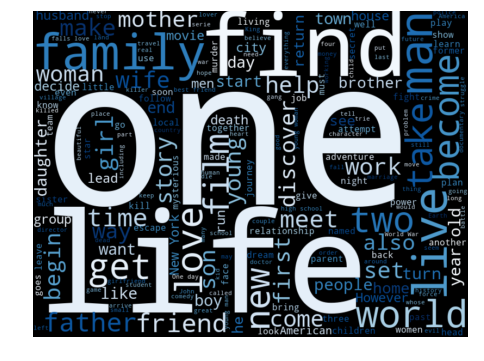

In [40]:
# Create a list of word
wc = WordCloud(
#     background_color="white", 
#     max_words=2000, 
    colormap="Blues",
    width=800, 
    height=600, 
    stopwords=stopwords_list, 
#     max_font_size=40, 
    margin=0, 
    random_state=42
)

# Generate word cloud
wc.generate(text)

# Plot word cloud
plt.figure(figsize=(8,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.savefig("Figures/word_cloud.png")

In [41]:
# df4 = pd.DataFrame()
# df4[sdf.columns.tolist()] = sdf
df4 = sdf

# Save checkpoint
df4.to_csv("Data/data_cleaning_43.csv", index=False)

### 4.4 Convert categorical features into binary values

In [65]:
# Load checkpoint
df4 = pd.read_csv("Data/data_cleaning_43.csv")

#### `cast`

In [66]:
# Find top 50 actors who appear most frequently
df4['cast'] = df4['cast'].apply(ast.literal_eval)
counter = Counter([item for sublist in df4['cast'].values for item in sublist])
top_actors = counter.most_common(50)
top_actors

[('John Wayne', 106),
 ('Jackie Chan', 89),
 ('Michael Caine', 86),
 ('Robert De Niro', 84),
 ('Gérard Depardieu', 82),
 ('Christopher Lee', 74),
 ('Nicolas Cage', 71),
 ('Bette Davis', 68),
 ('Samuel L. Jackson', 67),
 ('James Mason', 67),
 ('Bruce Willis', 64),
 ('Susan Sarandon', 64),
 ('Harvey Keitel', 63),
 ('Donald Sutherland', 63),
 ('Gene Hackman', 62),
 ('Jeff Bridges', 61),
 ('Cary Grant', 61),
 ('James Stewart', 60),
 ('Marcello Mastroianni', 59),
 ('Barbara Stanwyck', 58),
 ('Robert Mitchum', 58),
 ('Henry Fonda', 58),
 ('Catherine Deneuve', 57),
 ('Anthony Quinn', 57),
 ('Kirk Douglas', 57),
 ('Burt Lancaster', 57),
 ('Morgan Freeman', 56),
 ('Eric Roberts', 56),
 ('Alec Baldwin', 55),
 ('Helen Mirren', 55),
 ('Paul Newman', 55),
 ('Burt Reynolds', 55),
 ('John Cusack', 54),
 ('Meryl Streep', 54),
 ('Christopher Walken', 54),
 ('James Caan', 54),
 ('Joan Crawford', 54),
 ('Boris Karloff', 54),
 ('Vincent Price', 54),
 ('Tom Hanks', 53),
 ('Robin Williams', 53),
 ('Robert D

In [67]:
# For each movie, check whether a top-50 actor appeared
for name, count in top_actors:
#     print(f"Adding {name} to column...")
    
    for index, row in df4.iterrows():
        list_of_names = row['cast']
    
        if name in list_of_names:
            df4['cast_'+name] = 1
        else:
            df4['cast_'+name] = 0
            
# Drop the original column
df4 = df4.drop(columns=["cast"])

#### `genres`

In [68]:
# Find top 50 genres which are most poplular
df4['genres'] = df4['genres'].apply(ast.literal_eval)
counter = Counter([item for sublist in df4['genres'].values for item in sublist])
top_genres = counter.most_common(50)
top_genres

[('Drama', 20058),
 ('Comedy', 13073),
 ('Thriller', 7566),
 ('Romance', 6663),
 ('Action', 6542),
 ('Horror', 4634),
 ('Crime', 4283),
 ('Documentary', 3872),
 ('Adventure', 3468),
 ('Science Fiction', 3013),
 ('Family', 2740),
 ('Mystery', 2453),
 ('Fantasy', 2290),
 ('Animation', 1912),
 ('Music', 1587),
 ('Foreign', 1586),
 ('History', 1391),
 ('War', 1317),
 ('Western', 1038),
 ('TV Movie', 758)]

In [69]:
# For each movie, check whether a top-50 genres
for name, count in top_genres:
#     print(f"Adding {name} to column...")
    
    for index, row in df4.iterrows():
        list_of_names = row['genres']
    
        if name in list_of_names:
            df4['genre_'+name] = 1
        else:
            df4['genre_'+name] = 0
            
# Drop the original column
df4 = df4.drop(columns=["genres"])

#### `keywords`

In [70]:
# Find top 50 keywords which are most poplular
df4['keywords'] = df4['keywords'].apply(ast.literal_eval)
counter = Counter([item for sublist in df4['keywords'].values for item in sublist])
top_keywords = counter.most_common(50)
top_keywords

[('woman director', 3011),
 ('independent film', 1894),
 ('murder', 1279),
 ('based on novel', 815),
 ('musical', 718),
 ('sex', 677),
 ('violence', 646),
 ('nudity', 628),
 ('revenge', 616),
 ('biography', 608),
 ('suspense', 575),
 ('love', 560),
 ('female nudity', 554),
 ('sport', 528),
 ('police', 450),
 ('duringcreditsstinger', 440),
 ('teenager', 432),
 ('sequel', 428),
 ('friendship', 404),
 ('world war ii', 390),
 ('drug', 358),
 ('stand-up comedy', 347),
 ('prison', 346),
 ('high school', 313),
 ('martial arts', 310),
 ('suicide', 306),
 ('rape', 303),
 ('film noir', 301),
 ('silent film', 301),
 ('kidnapping', 299),
 ('family', 289),
 ('serial killer', 288),
 ('monster', 277),
 ('alien', 274),
 ('dystopia', 268),
 ('paris', 265),
 ('new york', 265),
 ('blood', 262),
 ('gay', 258),
 ('short', 254),
 ('marriage', 252),
 ('christmas', 249),
 ('gore', 242),
 ('gangster', 241),
 ('death', 241),
 ('small town', 236),
 ('zombie', 236),
 ('detective', 233),
 ('london england', 231),


In [71]:
# For each keyword, check whether a top-50 keywords
for name, count in top_keywords:
#     print(f"Adding {name} to column...")
    
    for index, row in df4.iterrows():
        list_of_names = row['keywords']
    
        if name in list_of_names:
            df4['keyword_'+name] = 1
        else:
            df4['keyword_'+name] = 0
            
# Drop the original column
df4 = df4.drop(columns=["keywords"])

50 most popular keywords:
Adding woman director to column...
Adding independent film to column...
Adding murder to column...
Adding based on novel to column...
Adding musical to column...
Adding sex to column...
Adding violence to column...
Adding nudity to column...
Adding revenge to column...
Adding biography to column...
Adding suspense to column...
Adding love to column...
Adding female nudity to column...
Adding sport to column...
Adding police to column...
Adding duringcreditsstinger to column...
Adding teenager to column...
Adding sequel to column...
Adding friendship to column...
Adding world war ii to column...
Adding drug to column...
Adding stand-up comedy to column...
Adding prison to column...
Adding high school to column...
Adding martial arts to column...
Adding suicide to column...
Adding rape to column...
Adding film noir to column...
Adding silent film to column...
Adding kidnapping to column...
Adding family to column...
Adding serial killer to column...
Adding monst

#### `production_countries`

In [72]:
# Find top 50 production_countries which are most poplular
df4['production_countries'] = df4['production_countries'].apply(ast.literal_eval)
counter = Counter([item for sublist in df4['production_countries'].values for item in sublist])
top_production_countries = counter.most_common(50)
top_production_countries

[('United States of America', 21005),
 ('United Kingdom', 4074),
 ('France', 3893),
 ('Germany', 2235),
 ('Italy', 2144),
 ('Canada', 1744),
 ('Japan', 1638),
 ('Spain', 956),
 ('Russia', 903),
 ('India', 821),
 ('Hong Kong', 591),
 ('Sweden', 584),
 ('Australia', 564),
 ('South Korea', 493),
 ('Belgium', 441),
 ('Denmark', 381),
 ('Finland', 378),
 ('China', 370),
 ('Netherlands', 370),
 ('Mexico', 327),
 ('Poland', 313),
 ('Brazil', 290),
 ('Switzerland', 251),
 ('Argentina', 249),
 ('Ireland', 224),
 ('Czech Republic', 208),
 ('Austria', 207),
 ('Norway', 199),
 ('Hungary', 168),
 ('Greece', 167),
 ('Turkey', 158),
 ('Israel', 145),
 ('Romania', 141),
 ('Taiwan', 128),
 ('Portugal', 128),
 ('South Africa', 123),
 ('New Zealand', 122),
 ('Thailand', 114),
 ('Serbia', 105),
 ('Iran', 100),
 ('Luxembourg', 87),
 ('Philippines', 81),
 ('Croatia', 77),
 ('Iceland', 66),
 ('Chile', 66),
 ('Estonia', 59),
 ('Bulgaria', 56),
 ('Ukraine', 55),
 ('Singapore', 40),
 ('Lithuania', 36)]

In [73]:
# For each movie, check whether a top-50 production country appeared
for name, count in top_production_countries:
#     print(f"Adding {name} to column...")
    
    for index, row in df4.iterrows():
        list_of_names = row['production_countries']
    
        if name in list_of_names:
            df4['production_country_'+name] = 1
        else:
            df4['production_country_'+name] = 0

# Drop the original column
df4 = df4.drop(columns=["production_countries"])

United States of America
United Kingdom
France
Germany
Italy
Canada
Japan
Spain
Russia
India
Hong Kong
Sweden
Australia
South Korea
Belgium
Denmark
Finland
China
Netherlands
Mexico
Poland
Brazil
Switzerland
Argentina
Ireland
Czech Republic
Austria
Norway
Hungary
Greece
Turkey
Israel
Romania
Taiwan
Portugal
South Africa
New Zealand
Thailand
Serbia
Iran
Luxembourg
Philippines
Croatia
Iceland
Chile
Estonia
Bulgaria
Ukraine
Singapore
Lithuania


#### `production_companies`

In [74]:
# Find top 50 production_companies which are most poplular
df4['production_companies'] = df4['production_companies'].apply(ast.literal_eval)
counter = Counter([item for sublist in df4['production_companies'].values for item in sublist])
top_production_companies = counter.most_common(50)
top_production_companies

[('Warner Bros.', 1248),
 ('Metro-Goldwyn-Mayer (MGM)', 1073),
 ('Paramount Pictures', 996),
 ('Twentieth Century Fox Film Corporation', 834),
 ('Universal Pictures', 827),
 ('Columbia Pictures Corporation', 447),
 ('Canal+', 433),
 ('Columbia Pictures', 429),
 ('RKO Radio Pictures', 290),
 ('United Artists', 276),
 ('New Line Cinema', 276),
 ('Walt Disney Pictures', 262),
 ('Touchstone Pictures', 224),
 ('TriStar Pictures', 197),
 ('Mosfilm', 186),
 ('Miramax Films', 182),
 ('France 2 Cinéma', 167),
 ('Centre National de la Cinématographie (CNC)', 160),
 ('Toho Company', 141),
 ('BBC Films', 130),
 ('Gaumont', 124),
 ('StudioCanal', 122),
 ('Relativity Media', 119),
 ('British Broadcasting Corporation (BBC)', 118),
 ('TF1 Films Production', 117),
 ('Walt Disney Productions', 116),
 ('Orion Pictures', 111),
 ('Village Roadshow Pictures', 106),
 ('Regency Enterprises', 105),
 ('Universal International Pictures (UI)', 97),
 ('Dimension Films', 96),
 ('Zweites Deutsches Fernsehen (ZDF)', 

In [75]:
# For each movie, check whether a top-50 actor appeared
for name, count in top_production_companies:
#     print(f"Adding {name} to column...")
    
    for index, row in df4.iterrows():
        list_of_names = row['production_companies']
    
        if name in list_of_names:
            df4['production_company_'+name] = 1
        else:
            df4['production_company_'+name] = 0
            
# Drop the original column
df4 = df4.drop(columns=["production_companies"])

Warner Bros.
Metro-Goldwyn-Mayer (MGM)
Paramount Pictures
Twentieth Century Fox Film Corporation
Universal Pictures
Columbia Pictures Corporation
Canal+
Columbia Pictures
RKO Radio Pictures
United Artists
New Line Cinema
Walt Disney Pictures
Touchstone Pictures
TriStar Pictures
Mosfilm
Miramax Films
France 2 Cinéma
Centre National de la Cinématographie (CNC)
Toho Company
BBC Films
Gaumont
StudioCanal
Relativity Media
British Broadcasting Corporation (BBC)
TF1 Films Production
Walt Disney Productions
Orion Pictures
Village Roadshow Pictures
Regency Enterprises
Universal International Pictures (UI)
Dimension Films
Zweites Deutsches Fernsehen (ZDF)
Lionsgate
DreamWorks SKG
Wild Bunch
Fox Searchlight Pictures
Hammer Film Productions
American International Pictures (AIP)
Svensk Filmindustri (SF)
Rai Cinema
Working Title Films
Hollywood Pictures
Channel Four Films
Shaw Brothers
Film i Väst
Nordisk Film
Film4
Lions Gate Films
TLA Releasing
Castle Rock Entertainment


#### `original_language` and `director`

In [76]:
# Find directors that appeared less than 10 times
director_10_less = df4['director'].value_counts().loc[df4['director'].value_counts()<10]
director_10_less_list = director_10_less.index.tolist()

# Find original_language that appeared less than 10 times
lang_10_less = df4['original_language'].value_counts().loc[df4['original_language'].value_counts()<10]
lang_10_less_list = lang_10_less.index.tolist()

In [77]:
# One-hot encoding on columns original_language and director
df4 = pd.get_dummies(df4, columns=['original_language'])
df4 = pd.get_dummies(df4, columns=['director'])

In [78]:
# Drop director_... columns for directors who appeared less than 10 times
director_column_drop = ["director_"+col for col in director_10_less_list]
df4 = df4.drop(columns = director_column_drop)

# Drop original_language_... columns for original_language that appeared less than 10 times
lang_column_drop = ["original_language_"+col for col in lang_10_less_list]
df4 = df4.drop(columns = lang_column_drop)

In [79]:
# Save checkpoint
df4.to_csv("Data/data_cleaning_44.csv", index=False)

### 4.5. Re-encode other non-numeric features

#### Extract date string into year, month, date

In [80]:
# Load checkpoint
df4 = pd.read_csv("Data/data_cleaning_44.csv")

df4["release_date"].head()

0    1995-10-30
1    1995-12-15
2    1995-12-22
3    1995-12-22
4    1995-02-10
Name: release_date, dtype: object

In [81]:
# Extract year, month, date from release_date column
def to_year(release_date):
    try:
        output = int(release_date.split('-')[0])
    except:
        output = np.nan
    return output

def to_month(release_date):
    try:
        output = int(release_date.split('-')[1])
    except:
        output = np.nan
    return output

def to_date(release_date):
    try:
        output = int(release_date.split('-')[2])
    except:
        output = np.nan
    return output
    
df4["release_year"] = df4["release_date"].apply(to_year)
df4["release_month"] = df4["release_date"].apply(to_month)
df4["release_day"] = df4["release_date"].apply(to_date)

# Drop the original release_date column
df4 = df4.drop(columns=['release_date'])

# Sanity check
df4[["release_year", "release_month", "release_day"]].head()

,release_year,release_month,release_day
0,1995.0,10.0,30.0
1,1995.0,12.0,15.0
2,1995.0,12.0,22.0
3,1995.0,12.0,22.0
4,1995.0,2.0,10.0


In [82]:
# Impute missing values for columns release_year, release_month, and release_day using the median
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
df4[['release_year', 'release_month', 'release_day']] = imp.fit_transform(
    df4[['release_year', 'release_month', 'release_day']])

#### `adult` and `video`: conver False/True to 0 and 1

In [86]:
df4[['adult','video']].dtypes

adult    int64
video     bool
dtype: object

In [85]:
# `adult` column
df4['adult'] = df4['adult'].replace({False: 0, True: 1})
df4['adult'].value_counts()

0    44976
1        8
Name: adult, dtype: int64

In [87]:
# `video` column
df4['video'] = df4['video'].replace({False: 0, True: 1})
df4['video'].value_counts()

0    44891
1       93
Name: video, dtype: int64

#### `popularity`: convert to float

In [88]:
# `popularity` column
df4['popularity'] = df4['popularity'].astype(float)
df4.dtypes.loc[df4.dtypes=='object']

imdb_id           object
original_title    object
poster_path       object
title             object
dtype: object

In [89]:
# Save as a checkpoint
df4.to_csv("Data/data_cleaning_45.csv", index=False)

## 5. Assess missing data in each row

In [90]:
# Load checkpoint
df5 = pd.read_csv("Data/data_cleaning_45.csv")

Text(0.5,0,'Proportion of missing data in each row')

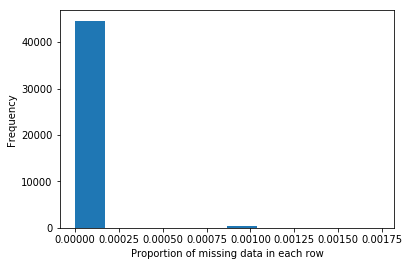

In [91]:
# How much data is missing in each row of the dataset?
df_clean_row = df5
missing_row = df_clean_row.isnull().sum(axis=1) / len(df_clean_row.columns)
missing_row.sort_values(ascending=False).plot.hist()
plt.xlabel("Proportion of missing data in each row")

Missing proportion > 0.0005 appears as outlier rows, so 0.0005 is chosen to be the threshold to divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We select at least five of these columns and compare the distribution of values.

This will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. 

We'll revisit these data later on. We continue our analysis for now using just the subset of the data with few or no missing values.

In [92]:
# Divide the data into two subsets based on the number of missing values in each row.
missing_many = df_clean_row.loc[missing_row >= 0.0005]
missing_few = df_clean_row.loc[missing_row < 0.0005]

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has be

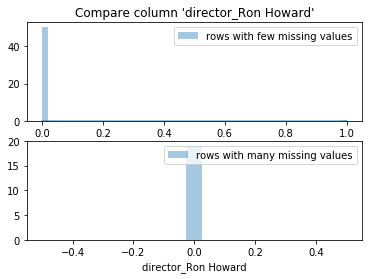

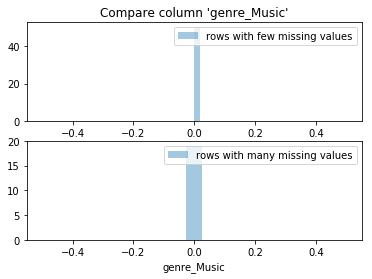

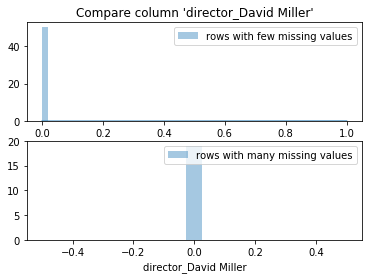

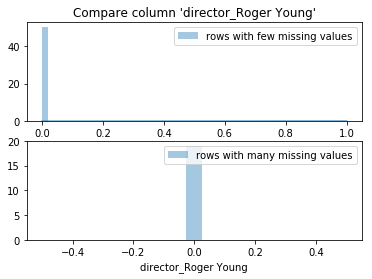

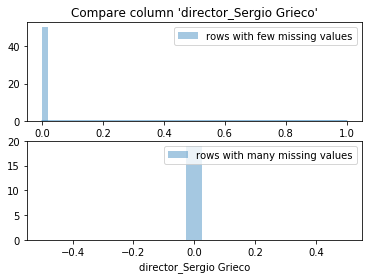

In [94]:
# Function to compare distribution
def compare_distribution(column_name):

    plt.figure()
    plt.subplot(211)
    sns.distplot(missing_few[column_name].dropna())
    plt.title(f"Compare column '{column_name}'")
    plt.legend(['rows with few missing values'])
    plt.subplot(212)
    sns.distplot(missing_many[column_name].dropna())
    plt.legend(['rows with many missing values'])
    
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
column_names = list(missing_few.columns)
for a in ['id', 'imdb_id', 'original_title', 'title', 
         ]:
    column_names.remove(a)

for column_name in random.sample(column_names, 5):
    compare_distribution(column_name)

The distributions of columns values for rows with few missing data vs. rows with many missing data are similar. Therefore, we can drop rows with many missing values without modify the distribution of features.

In [95]:
# Drop rows that have >0.0005 missing values
df5 = missing_few

#### Final check on missing values

Text(0.5,1,'Proportion of missing data in each column')

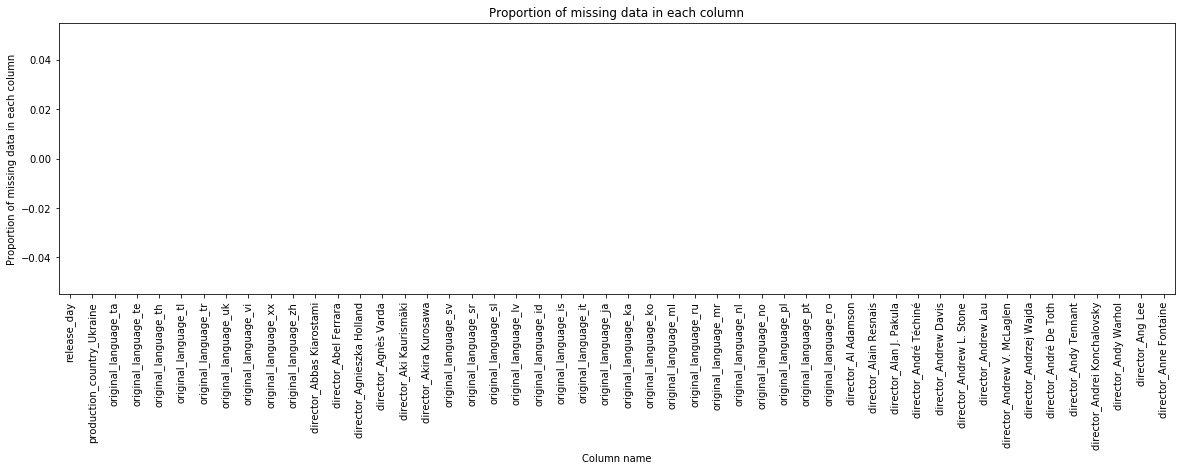

In [96]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_col = df5.isnull().sum() / len(df5.index)
missing_col.head()

# Investigate patterns in the amount of missing data in each column.
missing_col.sort_values(ascending=False)[0:50].plot.bar(figsize=(20,5))
plt.xlabel("Column name")
plt.ylabel("Proportion of missing data in each column")
plt.title("Proportion of missing data in each column")

In [107]:
# Save as checkpoint
df5.to_csv("Data/data_cleaning_5.csv", index=False)
df5.to_csv("Data/data_cleaning_5.csv.gz",index=False,compression="gzip")

#### Sanity check

In [101]:
df5.describe()

,overview_american,overview_away,overview_based,overview_beautiful,overview_begins,overview_best,overview_big,overview_boy,overview_brother,overview_children,...,director_Yasujirō Ozu,director_Yuen Woo-ping,director_Yves Simoneau,director_Yôji Yamada,director_Zhang Yimou,director_Álex de la Iglesia,director_Éric Rohmer,release_year,release_month,release_day
count,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,...,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000,44600.000000
mean,0.019627,0.011528,0.015279,0.013293,0.015472,0.015239,0.011905,0.015057,0.013412,0.012421,...,0.000673,0.000247,0.000247,0.000247,0.000404,0.000336,0.000605,1991.831771,6.471323,14.238386
std,0.101817,0.072118,0.087722,0.079969,0.083893,0.082961,0.077232,0.085534,0.083561,0.081663,...,0.025927,0.015703,0.015703,0.015703,0.020086,0.018336,0.024597,24.030808,3.620973,9.268822
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1874.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1978.000000,3.000000,6.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2001.000000,7.000000,14.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000,10.000000,22.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017.000000,12.000000,31.000000


In [108]:
df5.shape

(44600, 1153)

In [109]:
df5.dtypes.loc[df5.dtypes==object]

imdb_id           object
original_title    object
title             object
dtype: object